# Deeplabcut analysis

## Step 1: Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
import umap
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Step 2: Load the Data

In [16]:
path_to_extracted_folder = 'D:/deeplabcut/'
data_files = os.listdir(path_to_extracted_folder)
saline_files = [file for file in data_files if any(mouse in file for mouse in ['322', '328', '330', '332'])]
pfa_files = [file for file in data_files if any(mouse in file for mouse in ['326', '327', '334', '335', '336'])]

saline_dataframes = [pd.read_csv('D:/deeplabcut/' + file, header=[1,2]) for file in saline_files]
pfa_dataframes = [pd.read_csv('D:/deeplabcut/' + file, header=[1,2]) for file in pfa_files]

In [17]:
saline_dataframes_cropped = saline_dataframes
pfa_dataframes_cropped = pfa_dataframes

In [4]:
frame_info_df_manual = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_led_frames.csv')

In [39]:
for f in range(len(saline_dataframes)):
    shape = saline_dataframes_cropped[f].shape[0]
    print(f"The number of rows in saline_dataframes[{f}] is {shape}")


The number of rows in saline_dataframes[0] is 54000
The number of rows in saline_dataframes[1] is 54000
The number of rows in saline_dataframes[2] is 54000
The number of rows in saline_dataframes[3] is 54000
The number of rows in saline_dataframes[4] is 54000
The number of rows in saline_dataframes[5] is 54000
The number of rows in saline_dataframes[6] is 54000
The number of rows in saline_dataframes[7] is 54000


In [40]:
for f in range(len(pfa_dataframes)):
    shape = pfa_dataframes_cropped[f].shape[0]
    print(f"The number of rows in pfa_dataframes[{f}] is {shape}")

The number of rows in pfa_dataframes[0] is 54000
The number of rows in pfa_dataframes[1] is 54000
The number of rows in pfa_dataframes[2] is 54000
The number of rows in pfa_dataframes[3] is 54000
The number of rows in pfa_dataframes[4] is 54000
The number of rows in pfa_dataframes[5] is 54000
The number of rows in pfa_dataframes[6] is 54000
The number of rows in pfa_dataframes[7] is 54000
The number of rows in pfa_dataframes[8] is 54000
The number of rows in pfa_dataframes[9] is 54000


### data cropping to keep 54000 frames in each session

In [36]:
def crop_dataframe(df, file_name):
    # Extract the mouse name from the filename, stripping extensions or additional characters if needed
    mouse_name = file_name.split('DLC')[0].rstrip('_')
    start_frame = frame_info_df_manual[frame_info_df_manual['Filename'] == mouse_name]['Start'].values[0]
    return df.iloc[start_frame : start_frame + 54000]

saline_dataframes_cropped = [crop_dataframe(df, file) for df, file in zip(saline_dataframes, saline_files)]
pfa_dataframes_cropped = [crop_dataframe(df, file) for df, file in zip(pfa_dataframes, pfa_files)]


## Step 3: Data Cleaning

In [41]:
def clean_data_modified(df):
    # Create a copy of the dataframe
    df_copy = df.copy()
    
    # Replace missing values or NaN with interpolation on the copy
    df_copy.interpolate(method='linear', inplace=True, limit_direction='both')
    
    return df_copy

# Applying the modified function to the cropped dataframes
saline_dataframes_cleaned = [clean_data_modified(df) for df in saline_dataframes_cropped]
pfa_dataframes_cleaned = [clean_data_modified(df) for df in pfa_dataframes_cropped]


In [42]:
# List of specified body parts
body_parts = ['head', 'leftEar', 'rightEar', 'centerofMass', 'leftHip', 'rightHip', 'tailRoot']

def compute_center_coordinates(df):
    # Extracting x and y coordinates for the specified body parts
    x_coords = df.loc[:, pd.IndexSlice[body_parts, 'x']]
    y_coords = df.loc[:, pd.IndexSlice[body_parts, 'y']]
    
    # Computing average x and y coordinates across the body parts for each frame
    df['center_x'] = x_coords.median(axis=1)
    df['center_y'] = y_coords.median(axis=1)
    
    return df

# Applying the function to all dataframes in both conditions
saline_dataframes = [compute_center_coordinates(df) for df in saline_dataframes_cleaned]
pfa_dataframes = [compute_center_coordinates(df) for df in pfa_dataframes_cleaned]

saline_dataframes = [df.reset_index(drop=True) for df in saline_dataframes]
pfa_dataframes = [df.reset_index(drop=True) for df in pfa_dataframes]


# Checking the first few rows of the first dataframe in the saline condition to verify the new columns
saline_dataframes[0].head()


bodyparts miniscope_head                              snout               
     coords              x           y likelihood           x           y   
0      8576     841.260864  387.321960        1.0  862.359436  411.826202  \
1      8577     841.587097  387.586060        1.0  862.536377  411.923431   
2      8578     841.517151  387.464447        1.0  862.768555  411.958893   
3      8579     841.517090  387.465393        1.0  862.769287  411.958740   
4      8580     841.205139  387.916412        1.0  862.668884  412.120514   

                    head                         ...    tailRoot              
  likelihood           x           y likelihood  ...           y likelihood   
0   0.999712  875.362610  407.254944   0.999780  ...  389.657593   0.999991  \
1   0.999674  875.405762  407.328094   0.999792  ...  389.696228   0.999991   
2   0.999681  875.378113  407.393158   0.999802  ...  389.685394   0.999991   
3   0.999680  875.377502  407.393402   0.999802  ...  389.685486   0.999991   
4   0.999746  874.814392  407.451691   0.999786  ...  389.743561   0.999991   

      tailMid                            tailEnd                          
            x           y likelihood           x           y likelihood   
0  957.450745  330.619751   0.999948  959.282715  273.440857   0.999993  \
1  957.493896  330.628113   0.999947  959.305481  273.525452   0.999993   
2  957.498108  330.615387   0.999947  959.270630  273.461548   0.999993   
3  957.497864  330.613434   0.999947  959.269531  273.456726   0.999993   
4  957.490417  330.765564   0.999949  959.300720  273.823761   0.999993   

     center_x    center_y  
                           
0  911.807312  407.254944  
1  911.765747  407.328094  
2  911.791870  407.393158  
3  911.791870  407.393402  
4  911.842163  407.451691  

[5 rows x 39 columns]

In [43]:
saline_dataframes

[      bodyparts miniscope_head                              snout               
          coords              x           y likelihood           x           y   
 0          8576     841.260864  387.321960   1.000000  862.359436  411.826202  \
 1          8577     841.587097  387.586060   1.000000  862.536377  411.923431   
 2          8578     841.517151  387.464447   1.000000  862.768555  411.958893   
 3          8579     841.517090  387.465393   1.000000  862.769287  411.958740   
 4          8580     841.205139  387.916412   1.000000  862.668884  412.120514   
 ...         ...            ...         ...        ...         ...         ...   
 53995     62571     606.464539  173.683258   0.999996  626.430115  181.122467   
 53996     62572     608.818787  173.399139   0.999998  627.686279  183.489471   
 53997     62573     608.818420  173.398346   0.999998  627.685852  183.490509   
 53998     62574     612.314514  172.308624   0.999999  627.811279  182.697037   
 53999     62575

In [44]:
len(saline_dataframes_cleaned)


8

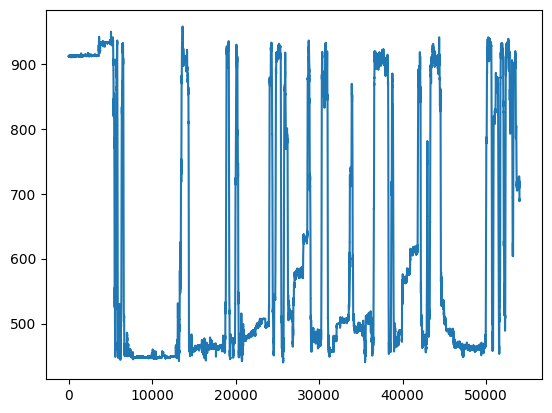

In [45]:
plt.plot(saline_dataframes[0]['center_x'])


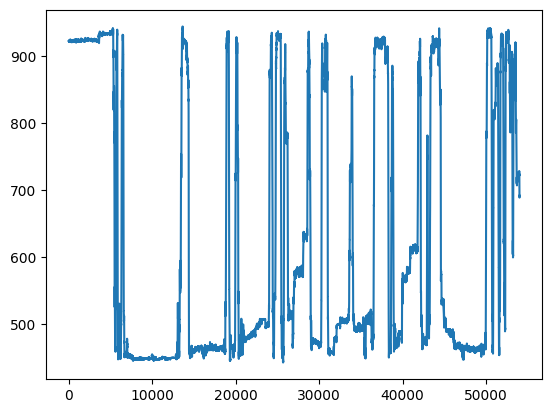

In [46]:
plt.plot(saline_dataframes[0]['centerofMass']['x'])

In [47]:
saline_dataframes[0]['center_x'].shape

(54000,)

## Behavior box center calculation

In [48]:
df_box = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_box_ccordinates.csv')

In [49]:
def calculate_center(row):
    box_center_x = (row['top_left_x'] + row['top_right_x'] + row['bottom_right_x'] + row['bottom_left_x']) / 4
    box_center_y = (row['top_left_y'] + row['top_right_y'] + row['bottom_right_y'] + row['bottom_left_y']) / 4
    return box_center_x, box_center_y

df_box['box_center_x'], df_box['box_center_y'] = zip(*df_box.apply(calculate_center, axis=1))


In [50]:
def adjust_coordinates(row):
    # Calculate width and length of the box
    width = row['top_right_x'] - row['top_left_x']
    length = row['bottom_left_y'] - row['top_left_y']
    
    # Calculate the center of the box
    center_x = (row['top_left_x'] + row['top_right_x'] + row['bottom_right_x'] + row['bottom_left_x']) / 4
    center_y = (row['top_left_y'] + row['top_right_y'] + row['bottom_right_y'] + row['bottom_left_y']) / 4
    
    # Adjust coordinates if aspect ratio isn't met
    if length != 2 * width:
        width = width
        length = 2 * width
        row['top_left_x'] = center_x - width / 2
        row['top_right_x'] = center_x + width / 2
        row['bottom_left_x'] = center_x - width / 2
        row['bottom_right_x'] = center_x + width / 2
        row['top_left_y'] = center_y - length / 2
        row['top_right_y'] = center_y - length / 2
        row['bottom_left_y'] = center_y + length / 2
        row['bottom_right_y'] = center_y + length / 2

    return row

# Adjusting the coordinates in df_box
df_box_adjusted = df_box.apply(adjust_coordinates, axis=1)


In [51]:
# Load the CSV data
df_box_coordinates = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_box_ccordinates.csv')

def compute_sub_rectangles(row):
    # Extract coordinates
    tl = np.array([row['top_left_x'], row['top_left_y']])
    tr = np.array([row['top_right_x'], row['top_right_y']])
    br = np.array([row['bottom_right_x'], row['bottom_right_y']])
    bl = np.array([row['bottom_left_x'], row['bottom_left_y']])
    
    # Calculate the vectors representing the sides
    top_vector = (tr - tl) / 8
    bottom_vector = (br - bl) / 8
    left_vector = (bl - tl) / 4
    right_vector = (br - tr) / 4
    
    sub_rects = []
    
    for i in range(4):
        for j in range(8):
            # Calculate the vertices of each sub-rectangle
            sub_tl = tl + j * top_vector + i * left_vector
            sub_tr = sub_tl + top_vector
            sub_bl = sub_tl + left_vector
            sub_br = sub_bl + top_vector
            
            sub_rects.append({
                'mouse_NO.': row['mouse_NO.'],
                'top_left_x': sub_tl[0],
                'top_left_y': sub_tl[1],
                'top_right_x': sub_tr[0],
                'top_right_y': sub_tr[1],
                'bottom_right_x': sub_br[0],
                'bottom_right_y': sub_br[1],
                'bottom_left_x': sub_bl[0],
                'bottom_left_y': sub_bl[1],
            })
    
    return sub_rects

# Compute sub-rectangles for all rows
all_sub_rectangles = []
for _, row in df_box_coordinates.iterrows():
    all_sub_rectangles.extend(compute_sub_rectangles(row))

# Convert results to DataFrame
df_sub_rectangles = pd.DataFrame(all_sub_rectangles)

df_sub_rectangles.head()
df_sub_rectangles.to_csv

<bound method NDFrame.to_csv of     mouse_NO.  top_left_x  top_left_y  top_right_x  top_right_y   
0         322      430.00      172.00       496.50       173.00  \
1         322      496.50      173.00       563.00       174.00   
2         322      563.00      174.00       629.50       175.00   
3         322      629.50      175.00       696.00       176.00   
4         322      696.00      176.00       762.50       177.00   
..        ...         ...         ...          ...          ...   
571   336_pfa      595.25      337.75       662.00       337.75   
572   336_pfa      662.00      337.75       728.75       337.75   
573   336_pfa      728.75      337.75       795.50       337.75   
574   336_pfa      795.50      337.75       862.25       337.75   
575   336_pfa      862.25      337.75       929.00       337.75   

     bottom_right_x  bottom_right_y  bottom_left_x  bottom_left_y  
0            494.50           238.5         428.00          237.5  
1            561.00        

In [52]:
df_sub_rectangles

,mouse_NO.,top_left_x,top_left_y,top_right_x,top_right_y,bottom_right_x,bottom_right_y,bottom_left_x,bottom_left_y
0,322,430.00,172.00,496.50,173.00,494.50,238.5,428.00,237.5
1,322,496.50,173.00,563.00,174.00,561.00,239.5,494.50,238.5
2,322,563.00,174.00,629.50,175.00,627.50,240.5,561.00,239.5
3,322,629.50,175.00,696.00,176.00,694.00,241.5,627.50,240.5
4,322,696.00,176.00,762.50,177.00,760.50,242.5,694.00,241.5
...,...,...,...,...,...,...,...,...,...
571,336_pfa,595.25,337.75,662.00,337.75,661.00,403.0,594.25,403.0
572,336_pfa,662.00,337.75,728.75,337.75,727.75,403.0,661.00,403.0
573,336_pfa,728.75,337.75,795.50,337.75,794.50,403.0,727.75,403.0
574,336_pfa,795.50,337.75,862.25,337.75,861.25,403.0,794.50,403.0


In [53]:
# Convert 'mouse_NO.' column to string type
df_sub_rectangles['mouse_NO.'] = df_sub_rectangles['mouse_NO.'].astype(str)

# Filter the dataframe based on mouse name containing specific strings
saline_group = df_sub_rectangles[df_sub_rectangles['mouse_NO.'].str.contains('322|328|330|332')]
pfa_group = df_sub_rectangles[df_sub_rectangles['mouse_NO.'].str.contains('326|327|334|335|336')]

# Re-index the two new dataframes
saline_group = saline_group.reset_index(drop=True)
pfa_group = pfa_group.reset_index(drop=True)

# Display the first few rows of each group
print(saline_group.head())
print(pfa_group.head())


  mouse_NO.  top_left_x  top_left_y  top_right_x  top_right_y  bottom_right_x   
0       322       430.0       172.0        496.5        173.0           494.5  \
1       322       496.5       173.0        563.0        174.0           561.0   
2       322       563.0       174.0        629.5        175.0           627.5   
3       322       629.5       175.0        696.0        176.0           694.0   
4       322       696.0       176.0        762.5        177.0           760.5   

   bottom_right_y  bottom_left_x  bottom_left_y  
0           238.5          428.0          237.5  
1           239.5          494.5          238.5  
2           240.5          561.0          239.5  
3           241.5          627.5          240.5  
4           242.5          694.0          241.5  
  mouse_NO.  top_left_x  top_left_y  top_right_x  top_right_y  bottom_right_x   
0       326       429.0      175.00        495.5       175.25          494.75  \
1       326       495.5      175.25        562.0   

In [54]:
saline_group['mouse_NO.']

0          322
1          322
2          322
3          322
4          322
        ...   
251    332_sal
252    332_sal
253    332_sal
254    332_sal
255    332_sal
Name: mouse_NO., Length: 256, dtype: object

In [55]:
pfa_group['mouse_NO.']

0          326
1          326
2          326
3          326
4          326
        ...   
315    336_pfa
316    336_pfa
317    336_pfa
318    336_pfa
319    336_pfa
Name: mouse_NO., Length: 320, dtype: object

In [56]:
df_sub_rectangles

,mouse_NO.,top_left_x,top_left_y,top_right_x,top_right_y,bottom_right_x,bottom_right_y,bottom_left_x,bottom_left_y
0,322,430.00,172.00,496.50,173.00,494.50,238.5,428.00,237.5
1,322,496.50,173.00,563.00,174.00,561.00,239.5,494.50,238.5
2,322,563.00,174.00,629.50,175.00,627.50,240.5,561.00,239.5
3,322,629.50,175.00,696.00,176.00,694.00,241.5,627.50,240.5
4,322,696.00,176.00,762.50,177.00,760.50,242.5,694.00,241.5
...,...,...,...,...,...,...,...,...,...
571,336_pfa,595.25,337.75,662.00,337.75,661.00,403.0,594.25,403.0
572,336_pfa,662.00,337.75,728.75,337.75,727.75,403.0,661.00,403.0
573,336_pfa,728.75,337.75,795.50,337.75,794.50,403.0,727.75,403.0
574,336_pfa,795.50,337.75,862.25,337.75,861.25,403.0,794.50,403.0


In [60]:
def rotate_points(points, angle, center):
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    translated_points = points - center
    rotated_points = rotation_matrix @ translated_points.T
    return rotated_points.T + center

def is_point_inside_rotated_rect(points, rect_coords):
    # Calculate the center and angle of the rectangle
    center = np.mean(rect_coords, axis=0)
    angle = np.arctan2(rect_coords[1, 1] - rect_coords[0, 1], rect_coords[1, 0] - rect_coords[0, 0])
    
    # Rotate points and rectangle to align with the axes
    rotated_points = rotate_points(points, -angle, center)
    rotated_rect = rotate_points(rect_coords, -angle, center)
    
    # Check if points are inside the aligned rectangle
    min_coords = rotated_rect.min(axis=0)
    max_coords = rotated_rect.max(axis=0)
    inside_x = (rotated_points[:, 0] >= min_coords[0]) & (rotated_points[:, 0] <= max_coords[0])
    inside_y = (rotated_points[:, 1] >= min_coords[1]) & (rotated_points[:, 1] <= max_coords[1])
    return inside_x & inside_y

def count_points_and_save_indices(df_sub_rectangles, dataframes):
    sub_box_indices = {i: [] for i in range(32)}
    
    for session in range(len(dataframes)):
        print(f"\nSession: {session}")
        
        if session >= len(dataframes):
            print(f"Warning: No data for session {session}. Skipping this session.")
            continue
        
        # Get coordinates for all sub-boxes
        sub_box_coords = np.array([
            df_sub_rectangles.iloc[session * 32 + box - 1][['top_left_x', 'top_left_y', 'top_right_x', 'top_right_y',
                                                           'bottom_right_x', 'bottom_right_y', 'bottom_left_x', 'bottom_left_y']].values.reshape(-1, 2)
            for box in range(1, 33)
        ])
        
        # Get points
        points = dataframes[session][['center_x', 'center_y']].values
        
        # Check each point
        for i, point in enumerate(points):
            # Check if point is inside any of the sub-boxes
            for box_index, sub_box in enumerate(sub_box_coords, start=1):
                if is_point_inside_rotated_rect(point.reshape(1, -1), sub_box):
                    sub_box_indices[box_index - 1].append((session, i))
                    break
                    
    return sub_box_indices


In [ ]:
indice_sal = count_points_and_save_indices(saline_group, saline_dataframes)

In [ ]:
indice_pfa = count_points_and_save_indices(pfa_group, pfa_dataframes)

In [57]:
def rotate_points(points, angle, center):
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    translated_points = points - center
    rotated_points = rotation_matrix @ translated_points.T
    return rotated_points.T + center

def is_point_inside_rotated_rect(points, rect_coords):
    # Calculate the center and angle of the rectangle
    center = np.mean(rect_coords, axis=0)
    angle = np.arctan2(rect_coords[1, 1] - rect_coords[0, 1], rect_coords[1, 0] - rect_coords[0, 0])
    
    # Rotate points and rectangle to align with the axes
    rotated_points = rotate_points(points, -angle, center)
    rotated_rect = rotate_points(rect_coords, -angle, center)
    
    # Check if points are inside the aligned rectangle
    min_coords = rotated_rect.min(axis=0)
    max_coords = rotated_rect.max(axis=0)
    inside_x = (rotated_points[:, 0] >= min_coords[0]) & (rotated_points[:, 0] <= max_coords[0])
    inside_y = (rotated_points[:, 1] >= min_coords[1]) & (rotated_points[:, 1] <= max_coords[1])
    return inside_x & inside_y

#def count_points_in_boxes(df_sub_rectangles, dataframes, edge_boxes=[1, 8, 25, 32], center_boxes=[12, 13, 20, 21]):
def count_points_in_boxes(df_sub_rectangles, dataframes, edge_boxes=[1,2,9,10, 7,8,15,16, 17,18,25,26, 23,24,31,32], center_boxes=[12, 13, 20, 21]):
#def count_points_in_boxes(df_sub_rectangles, dataframes, edge_boxes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], center_boxes=[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]):


    for session in range(len(dataframes)):
        print(f"\nSession: {session}")
        edge_count = 0
        center_count = 0
        
        if session >= len(dataframes):
            print(f"Warning: No data for session {session}. Skipping this session.")
            continue
        
        # Get coordinates for edge and center boxes
        edge_box_coords = np.array([
            df_sub_rectangles.iloc[session * 32 + box - 1][['top_left_x', 'top_left_y', 'top_right_x', 'top_right_y',
                                                           'bottom_right_x', 'bottom_right_y', 'bottom_left_x', 'bottom_left_y']].values.reshape(-1, 2)
            for box in edge_boxes
        ])
        center_box_coords = np.array([
            df_sub_rectangles.iloc[session * 32 + box - 1][['top_left_x', 'top_left_y', 'top_right_x', 'top_right_y',
                                                           'bottom_right_x', 'bottom_right_y', 'bottom_left_x', 'bottom_left_y']].values.reshape(-1, 2)
            for box in center_boxes
        ])
        
        # Get points
        points = dataframes[session][['center_x', 'center_y']].values
        
        # Check each point
        for point in points:
            # Check if point is inside any of the edge boxes
            for edge_box in edge_box_coords:
                if is_point_inside_rotated_rect(point.reshape(1, -1), edge_box):
                    edge_count += 1
                    break
            else:
                # Check if point is inside any of the center boxes
                for center_box in center_box_coords:
                    if is_point_inside_rotated_rect(point.reshape(1, -1), center_box):
                        center_count += 1
                        break
        
        print("Edge count:", edge_count)
        print("Center count:", center_count)

# Example usage
# count_points_in_boxes(df_sub_rectangles, dataframes)


In [58]:
range(len(saline_dataframes)-1)

range(0, 7)

In [59]:
edge_count, center_count = count_points_in_boxes(saline_group, saline_dataframes)
print("Number of points in edge boxes:", edge_count)
print("Number of points in center boxes:", center_count)


Session: 0
Edge count: 46899
Center count: 312

Session: 1
Edge count: 48822
Center count: 50

Session: 2
Edge count: 35916
Center count: 6881

Session: 3
Edge count: 50710
Center count: 211

Session: 4
Edge count: 28407
Center count: 6007

Session: 5
Edge count: 47949
Center count: 1694

Session: 6
Edge count: 33095
Center count: 3773

Session: 7
Edge count: 35270
Center count: 7441


TypeError: cannot unpack non-iterable NoneType object

In [35]:
edge_count, center_count = count_points_in_boxes(pfa_group, pfa_dataframes)
print("Number of points in edge boxes:", edge_count)
print("Number of points in center boxes:", center_count)


Session: 0
Edge count: 11289
Center count: 45185

Session: 1
Edge count: 51912
Center count: 3449

Session: 2
Edge count: 26338
Center count: 29424

Session: 3
Edge count: 3442
Center count: 51194

Session: 4
Edge count: 39686
Center count: 20115

Session: 5
Edge count: 21867
Center count: 33170

Session: 6
Edge count: 18735
Center count: 41278

Session: 7
Edge count: 35433
Center count: 19421

Session: 8
Edge count: 33468
Center count: 31825

Session: 9
Edge count: 23170
Center count: 37062


TypeError: cannot unpack non-iterable NoneType object

In [94]:
print(pfa_files)

['326DLC_resnet50_SP_behaviorOct10shuffle1_800000.csv', '326_PFADLC_resnet50_SP_behaviorOct10shuffle1_800000.csv', '327DLC_resnet50_SP_behaviorOct10shuffle1_800000.csv', '327_PFADLC_resnet50_SP_behaviorOct10shuffle1_800000.csv', '334DLC_resnet50_SP_behaviorOct10shuffle1_800000.csv', '334_PFADLC_resnet50_SP_behaviorOct10shuffle1_800000.csv', '335DLC_resnet50_SP_behaviorOct10shuffle1_800000.csv', '335_PFADLC_resnet50_SP_behaviorOct10shuffle1_800000.csv', '336DLC_resnet50_SP_behaviorOct10shuffle1_800000.csv', '336_PFADLC_resnet50_SP_behaviorOct10shuffle1_800000.csv']


## Step 4: Calculate Euclidean Distance from Reference Point

In [34]:
def calculate_euclidean_distance(df):
    distance_df = pd.DataFrame()
    body_parts = [col for col in df.columns.get_level_values(0).unique() if col not in ['bodyparts', 'likelihood']]
    for body_part in body_parts:
        x = df[(body_part, 'x')]
        y = df[(body_part, 'y')]
        distance = np.sqrt(x**2 + y**2)
        distance_df[body_part] = distance
    return distance_df

saline_data_distance = [calculate_euclidean_distance(df) for df in saline_dataframes]
pfa_data_distance = [calculate_euclidean_distance(df) for df in pfa_dataframes]

In [45]:
saline_data_distance[1].shape

(56312, 12)

## Step 5: Apply PCA for Dimensionality Reduction (Optional, but can speed up t-SNE)

In [49]:
all_data_distance = pd.concat([pd.concat(saline_data_distance), pd.concat(pfa_data_distance)], axis=0)

# Ensure n_components is less than or equal to min(n_samples, n_features)
# n_components = min(50, all_data_distance.shape[0], all_data_distance.shape[1])
n_components = 2

pca = PCA(n_components=n_components)  
data_pca = pca.fit_transform(all_data_distance)


(511209, 2)


<function matplotlib.pyplot.show(close=None, block=None)>

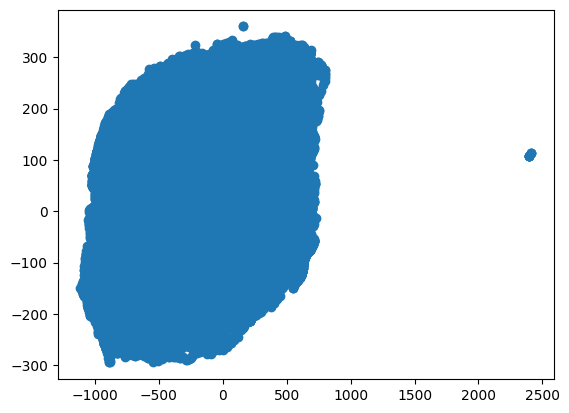

In [53]:
print(np.shape(data_pca))
plt.scatter(data_pca[:,0], data_pca[:,1])
plt.show

## Step 6: Apply t-SNE for Visualization

In [54]:
tsne = TSNE(n_components=2, perplexity=200)
data_tsne = tsne.fit_transform(all_data_distance)

plt.figure(figsize=(10, 6))
plt.scatter(data_tsne[:len(pd.concat(saline_data_distance)), 0], 
            data_tsne[:len(pd.concat(saline_data_distance)), 1], 
            marker='o', color='red', alpha=0.7, label='saline')
plt.scatter(data_tsne[len(pd.concat(saline_data_distance)):, 0], 
            data_tsne[len(pd.concat(saline_data_distance)):, 1], 
            marker='s', color='blue', alpha=0.7, label='pfa')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper right')
plt.title('t-SNE Visualization of Euclidean Distance Representation')
plt.grid(True)
plt.show()


KeyboardInterrupt: 

## Step 7: Apply UMAP for Visualization

In [29]:
reducer = umap.UMAP(random_state=42)
data_umap = reducer.fit_transform(data_pca)

plt.figure(figsize=(10, 6))
plt.scatter(data_umap[:len(pd.concat(saline_data_distance)), 0], 
            data_umap[:len(pd.concat(saline_data_distance)), 1], 
            marker='o', color='red', alpha=0.7, label='saline')
plt.scatter(data_umap[len(pd.concat(saline_data_distance)):, 0], 
            data_umap[len(pd.concat(saline_data_distance)):, 1], 
            marker='s', color='blue', alpha=0.7, label='pfa')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(loc='upper right')
plt.title('UMAP Visualization of Euclidean Distance Representation')
plt.grid(True)
plt.show()

C:\Users\huang\AppData\Local\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\huang\AppData\Local\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 